In [ ]:
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 75.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
bigframes 2.8.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which

In [2]:
!apt update
!apt install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb ffmpeg xorg-dev python-opengl libboost-all-dev libsdl2-dev swig

!pip3 install pyvirtualdisplay piglet gym torch torchvision
!pip3 install "gym[atari]"

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,801 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,067 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,561 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.ne

In [4]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt
from gym.wrappers import RecordVideo
import os
import base64
from IPython.display import HTML

# Среда
env = gym.make('CartPole-v1', render_mode='rgb_array')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Гиперпараметры
LR = 0.001
GAMMA = 0.99
BATCH_SIZE = 64
MEMORY_SIZE = 10000  # Размер датасета
ITERATIONS = 20      # Количество итераций FQI
EPISODES_EVAL = 10   # Эпизодов для оценки после каждой итерации

# Q-сеть
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Сбор датасета (рандомная политика)
def collect_dataset(env, num_samples):
    dataset = []
    state = env.reset()

    while len(dataset) < num_samples:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        dataset.append((state, action, reward, next_state, done))

        state = next_state
        if done:
            state, _ = env.reset()

    return dataset

# Fitted Q-Iteration
def fitted_q_iteration(dataset, q_net, iterations, batch_size=64):
    optimizer = optim.Adam(q_net.parameters(), lr=LR)
    loss_fn = nn.MSELoss()

    for _ in range(iterations):
        # Перемешиваем датасет
        np.random.shuffle(dataset)

        # Разбиваем на батчи
        for i in range(0, len(dataset), batch_size):
            batch = dataset[i:i+batch_size]

            states = torch.tensor(np.array([x[0] for x in batch]))
            actions = torch.LongTensor(np.array([x[1] for x in batch]))
            rewards = torch.FloatTensor(np.array([x[2] for x in batch]))
            next_states = torch.FloatTensor(np.array([x[3] for x in batch]))
            dones = torch.FloatTensor(np.array([x[4] for x in batch]))

            # Вычисляем целевые Q-значения
            with torch.no_grad():
                next_q = q_net(next_states).max(1)[0]
                target_q = rewards + (1 - dones) * GAMMA * next_q

            # Текущие Q-значения
            current_q = q_net(states).gather(1, actions.unsqueeze(1))

            # Оптимизация
            loss = loss_fn(current_q, target_q.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# Оценка политики
def evaluate_policy(env, q_net, num_episodes, record=False):
    if record:
        env = RecordVideo(env, 'videos', episode_trigger=lambda x: x == 0)

    rewards = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0

        while True:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                action = q_net(state_tensor).argmax().item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            state = next_state

            if done:
                break

        rewards.append(total_reward)

    if record:
        env.close()

    return np.mean(rewards)

# Основной процесс
if __name__ == "__main__":
    # 1. Сбор датасета
    print("Собираем датасет...")
    dataset = collect_dataset(env, MEMORY_SIZE)

    # 2. Инициализация Q-сети
    q_net = QNetwork(state_dim, action_dim)

    # 3. Обучение FQI
    print("Запускаем Fitted Q-Iteration...")
    evaluation_results = []

    for iteration in range(ITERATIONS):
        fitted_q_iteration(dataset, q_net, iterations=1)

        # Оценка после каждой итерации
        mean_reward = evaluate_policy(env, q_net, EPISODES_EVAL)
        evaluation_results.append(mean_reward)
        print(f"Iteration {iteration+1}/{ITERATIONS}, Mean Reward: {mean_reward:.1f}")

    # Финальная оценка с записью видео
    print("Финальная оценка с записью видео...")
    _ = evaluate_policy(env, q_net, 1, record=True)

    # Визуализация результатов
    plt.figure(figsize=(12, 6))
    plt.plot(evaluation_results)
    plt.xlabel('Iteration')
    plt.ylabel('Mean Reward')
    plt.title('Fitted Q-Iteration Performance')
    plt.grid()
    plt.show()

    # Показать видео
    def show_video(video_path):
        video_files = [f for f in os.listdir(video_path) if f.endswith('.mp4')]
        if not video_files:
            print("No videos found")
            return

        latest_video = max(video_files, key=lambda x: os.path.getctime(os.path.join(video_path, x)))
        video_file = open(os.path.join(video_path, latest_video), 'rb').read()
        encoded = base64.b64encode(video_file).decode('utf-8')
        return HTML(f'''
            <video width="640" height="480" controls>
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4">
            </video>
        ''')

    show_video('videos')

Собираем датасет...
Запускаем Fitted Q-Iteration...


/tmp/ipython-input-4-1303967933.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  states = torch.tensor(np.array([x[0] for x in batch]))


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

Using Gym version: 0.26.2
Собираем датасет...
Запускаем Fitted Q-Iteration...
Iteration 1/20, Mean Reward: 9.8
Iteration 2/20, Mean Reward: 9.4
Iteration 3/20, Mean Reward: 9.6
Iteration 4/20, Mean Reward: 9.2
Iteration 5/20, Mean Reward: 46.9
Iteration 6/20, Mean Reward: 80.7
Iteration 7/20, Mean Reward: 43.0
Iteration 8/20, Mean Reward: 104.8
Iteration 9/20, Mean Reward: 66.4
Iteration 10/20, Mean Reward: 113.1
Iteration 11/20, Mean Reward: 77.1
Iteration 12/20, Mean Reward: 105.8
Iteration 13/20, Mean Reward: 89.3
Iteration 14/20, Mean Reward: 90.3
Iteration 15/20, Mean Reward: 191.7
Iteration 16/20, Mean Reward: 96.0
Iteration 17/20, Mean Reward: 107.5
Iteration 18/20, Mean Reward: 234.8
Iteration 19/20, Mean Reward: 113.5
Iteration 20/20, Mean Reward: 173.6
Финальная оценка...
Moviepy - Building video /content/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/rl-video-episode-0.mp4


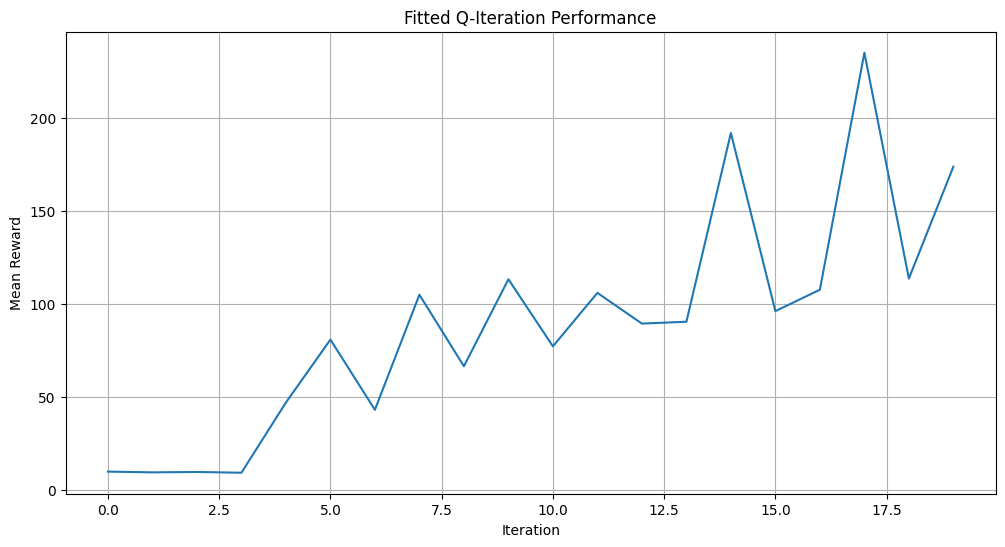

In [5]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt
from gym.wrappers import RecordVideo
import os
import base64
from IPython.display import HTML

# Проверяем версию Gym и настраиваем среду соответственно
gym_version = gym.__version__
print(f"Using Gym version: {gym_version}")

if gym_version >= '0.26.0':
    env = gym.make('CartPole-v1', render_mode='rgb_array')
else:
    env = gym.make('CartPole-v1')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Гиперпараметры
LR = 0.001
GAMMA = 0.99
BATCH_SIZE = 64
MEMORY_SIZE = 10000
ITERATIONS = 20
EPISODES_EVAL = 10

# Q-сеть
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Универсальная функция сбора данных для разных версий Gym
def collect_dataset(env, num_samples):
    dataset = []

    # По-разному сбрасываем среду для разных версий Gym
    if gym_version >= '0.26.0':
        state, _ = env.reset()
    else:
        state = env.reset()

    while len(dataset) < num_samples:
        action = env.action_space.sample()

        # Обрабатываем разные форматы вывода step()
        if gym_version >= '0.26.0':
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        else:
            next_state, reward, done, _ = env.step(action)

        dataset.append((state, action, reward, next_state, done))

        state = next_state
        if done:
            if gym_version >= '0.26.0':
                state, _ = env.reset()
            else:
                state = env.reset()

    return dataset

# Fitted Q-Iteration (без изменений)
def fitted_q_iteration(dataset, q_net, iterations, batch_size=64):
    optimizer = optim.Adam(q_net.parameters(), lr=LR)
    loss_fn = nn.MSELoss()

    for _ in range(iterations):
        np.random.shuffle(dataset)

        for i in range(0, len(dataset), batch_size):
            batch = dataset[i:i+batch_size]

            states = torch.FloatTensor(np.array([x[0] for x in batch]))
            actions = torch.LongTensor(np.array([x[1] for x in batch]))
            rewards = torch.FloatTensor(np.array([x[2] for x in batch]))
            next_states = torch.FloatTensor(np.array([x[3] for x in batch]))
            dones = torch.FloatTensor(np.array([x[4] for x in batch]))

            with torch.no_grad():
                next_q = q_net(next_states).max(1)[0]
                target_q = rewards + (1 - dones) * GAMMA * next_q

            current_q = q_net(states).gather(1, actions.unsqueeze(1))
            loss = loss_fn(current_q, target_q.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# Универсальная функция оценки политики
def evaluate_policy(env, q_net, num_episodes, record=False):
    if record and gym_version >= '0.26.0':
        env = RecordVideo(env, 'videos', episode_trigger=lambda x: x == 0)

    rewards = []
    for episode in range(num_episodes):
        if gym_version >= '0.26.0':
            state, _ = env.reset()
        else:
            state = env.reset()

        total_reward = 0
        done = False

        while not done:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                action = q_net(state_tensor).argmax().item()

            if gym_version >= '0.26.0':
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
            else:
                next_state, reward, done, _ = env.step(action)

            total_reward += reward
            state = next_state

        rewards.append(total_reward)

    if record and gym_version >= '0.26.0':
        env.close()

    return np.mean(rewards)

# Основной процесс
if __name__ == "__main__":
    print("Собираем датасет...")
    dataset = collect_dataset(env, MEMORY_SIZE)

    q_net = QNetwork(state_dim, action_dim)

    print("Запускаем Fitted Q-Iteration...")
    evaluation_results = []

    for iteration in range(ITERATIONS):
        fitted_q_iteration(dataset, q_net, iterations=1)
        mean_reward = evaluate_policy(env, q_net, EPISODES_EVAL)
        evaluation_results.append(mean_reward)
        print(f"Iteration {iteration+1}/{ITERATIONS}, Mean Reward: {mean_reward:.1f}")

    print("Финальная оценка...")
    if gym_version >= '0.26.0':
        _ = evaluate_policy(env, q_net, 1, record=True)
    else:
        print("Запись видео не поддерживается в этой версии Gym")

    # Визуализация
    plt.figure(figsize=(12, 6))
    plt.plot(evaluation_results)
    plt.xlabel('Iteration')
    plt.ylabel('Mean Reward')
    plt.title('Fitted Q-Iteration Performance')
    plt.grid()
    plt.show()

    # Показать видео (только для новых версий Gym)
    if gym_version >= '0.26.0':
        def show_video(video_path):
            video_files = [f for f in os.listdir(video_path) if f.endswith('.mp4')]
            if not video_files:
                print("No videos found")
                return

            latest_video = max(video_files, key=lambda x: os.path.getctime(os.path.join(video_path, x)))
            video_file = open(os.path.join(video_path, latest_video), 'rb').read()
            encoded = base64.b64encode(video_file).decode('utf-8')
            return HTML(f'''
                <video width="640" height="480" controls>
                    <source src="data:video/mp4;base64,{encoded}" type="video/mp4">
                </video>
            ''')

        show_video('videos')